In [13]:
import pymc as pm
import numpy as np
import arviz as az
import matplotlib.pyplot as plt
import scipy.stats as stats

In [2]:
%config InlineBackend.figure_format = 'retina'
RANDOM_SEED = 8927
rng = np.random.default_rng(RANDOM_SEED)
az.style.use("arviz-darkgrid")

## 2.1

In [3]:
ways = np.array([0, 3, 8, 9, 0])
ways / ways.sum()

array([0.  , 0.15, 0.4 , 0.45, 0.  ])

## 2.2

The probability of observing six W's in 9 tosses:

In [4]:
stats.binom.pmf(6, n=9, p=0.5)

0.16406250000000003

## 2.3 and 2.5

**The code in PyMC had this as 5 but I think this can be really any number since we're just using a 
uniform prior and aren't make any assumptions about the plausible values about pi**

* It justs has to be the same length as the grid we define.

In [5]:
def uniform_prior(grid_points):
    return np.repeat(1, grid_points)

def truncated_prior(grid_points, trunc_point=0.5):
    return (np.linspace(0, 1, grid_points) >= trunc_point).astype(int)

def double_exp_prior(grid_points):
    return np.exp(-5 * abs(np.linspace(0, 1, grid_points) - 0.5))

This makes the code clearer to me - we're assigning the same probability to each possible value that $\pi$ can take, which is defined by the size of our grid.

In [6]:
def test_uniform(grid_points):
    return np.repeat(1, grid_points) / grid_points

In [7]:
test_uniform(50)

array([0.02, 0.02, 0.02, 0.02, 0.02, 0.02, 0.02, 0.02, 0.02, 0.02, 0.02,
       0.02, 0.02, 0.02, 0.02, 0.02, 0.02, 0.02, 0.02, 0.02, 0.02, 0.02,
       0.02, 0.02, 0.02, 0.02, 0.02, 0.02, 0.02, 0.02, 0.02, 0.02, 0.02,
       0.02, 0.02, 0.02, 0.02, 0.02, 0.02, 0.02, 0.02, 0.02, 0.02, 0.02,
       0.02, 0.02, 0.02, 0.02, 0.02, 0.02])

* We use `pmf()` since a Binomial is a discrete distribution.

In [8]:
def binom_post_grid_approx(prior_func, grid_points=5, success=6, tosses=9):
    p_grid = np.linspace(0, 1, grid_points)
    
    prior = prior_func(grid_points)
    likelihood = stats.binom.pmf(success, tosses, p_grid)
    
    unstd_posterior = likelihood * prior
    
    posterior = unstd_posterior / unstd_posterior.sum()
    return p_grid, posterior

In [9]:
grid_points = 10

prior = uniform_prior(grid_points)
grid = np.linspace(0, 1, grid_points)
likelihood = stats.binom.pmf(6, 9, grid)

unstd_posterior = likelihood * prior
(unstd_posterior / unstd_posterior.sum()).sum()


1.0

## 2.3

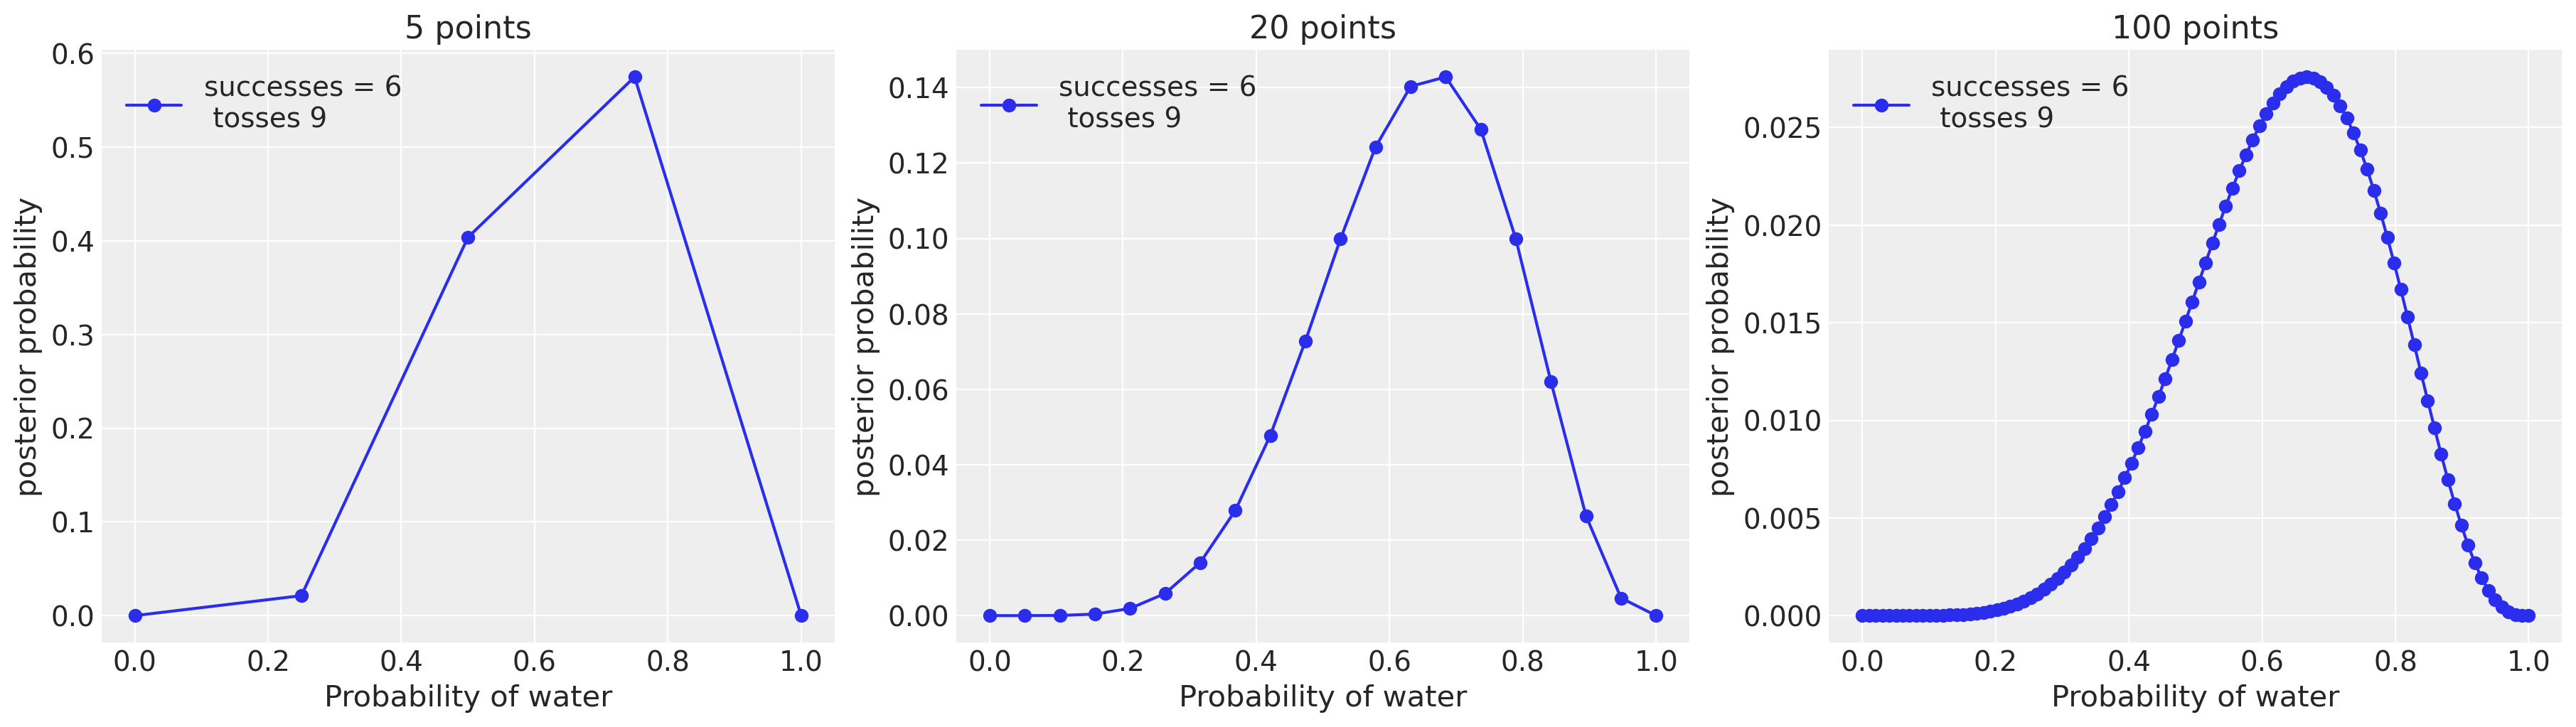

In [10]:
w, n = 6, 9

points = (5, 20, 100)

_, ax = plt.subplots(1, len(points), figsize=(6 * len(points), 5))
for idx, ps in enumerate(points):
    p_grid, posterior = binom_post_grid_approx(test_uniform, ps, w, n)
    ax[idx].plot(p_grid, posterior, "o-", label=f"successes = {w}\n tosses {n}")
    ax[idx].set_xlabel("Probability of water")
    ax[idx].set_ylabel("posterior probability")
    ax[idx].set_title(f"{ps} points")
    ax[idx].legend(loc=0)

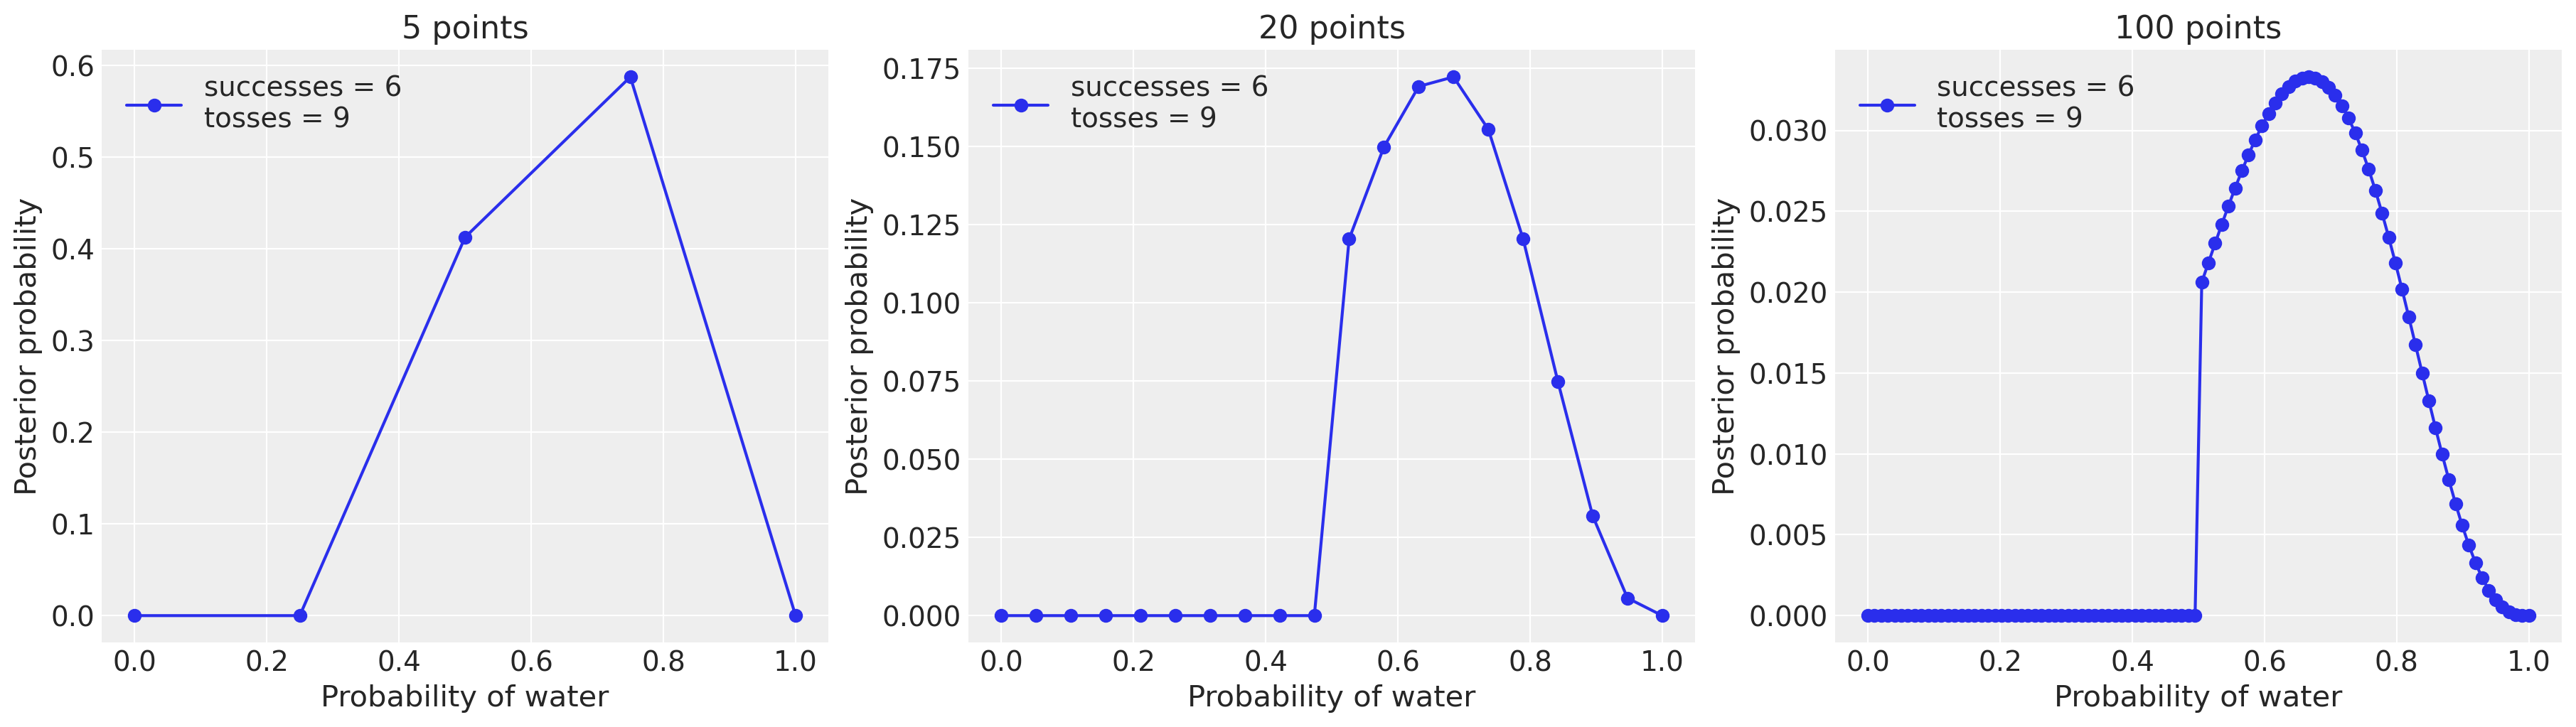

In [11]:
_, ax = plt.subplots(1, len(points), figsize=(6 * len(points), 5))
for idx, ps in enumerate(points):
    p_grid, posterior = binom_post_grid_approx(truncated_prior, ps, w, n)
    ax[idx].plot(p_grid, posterior, "o-", label=f"successes = {w}\ntosses = {n}")
    ax[idx].set_xlabel("Probability of water")
    ax[idx].set_ylabel("Posterior probability")
    ax[idx].set_title(f"{ps} points")
    ax[idx].legend(loc=0)

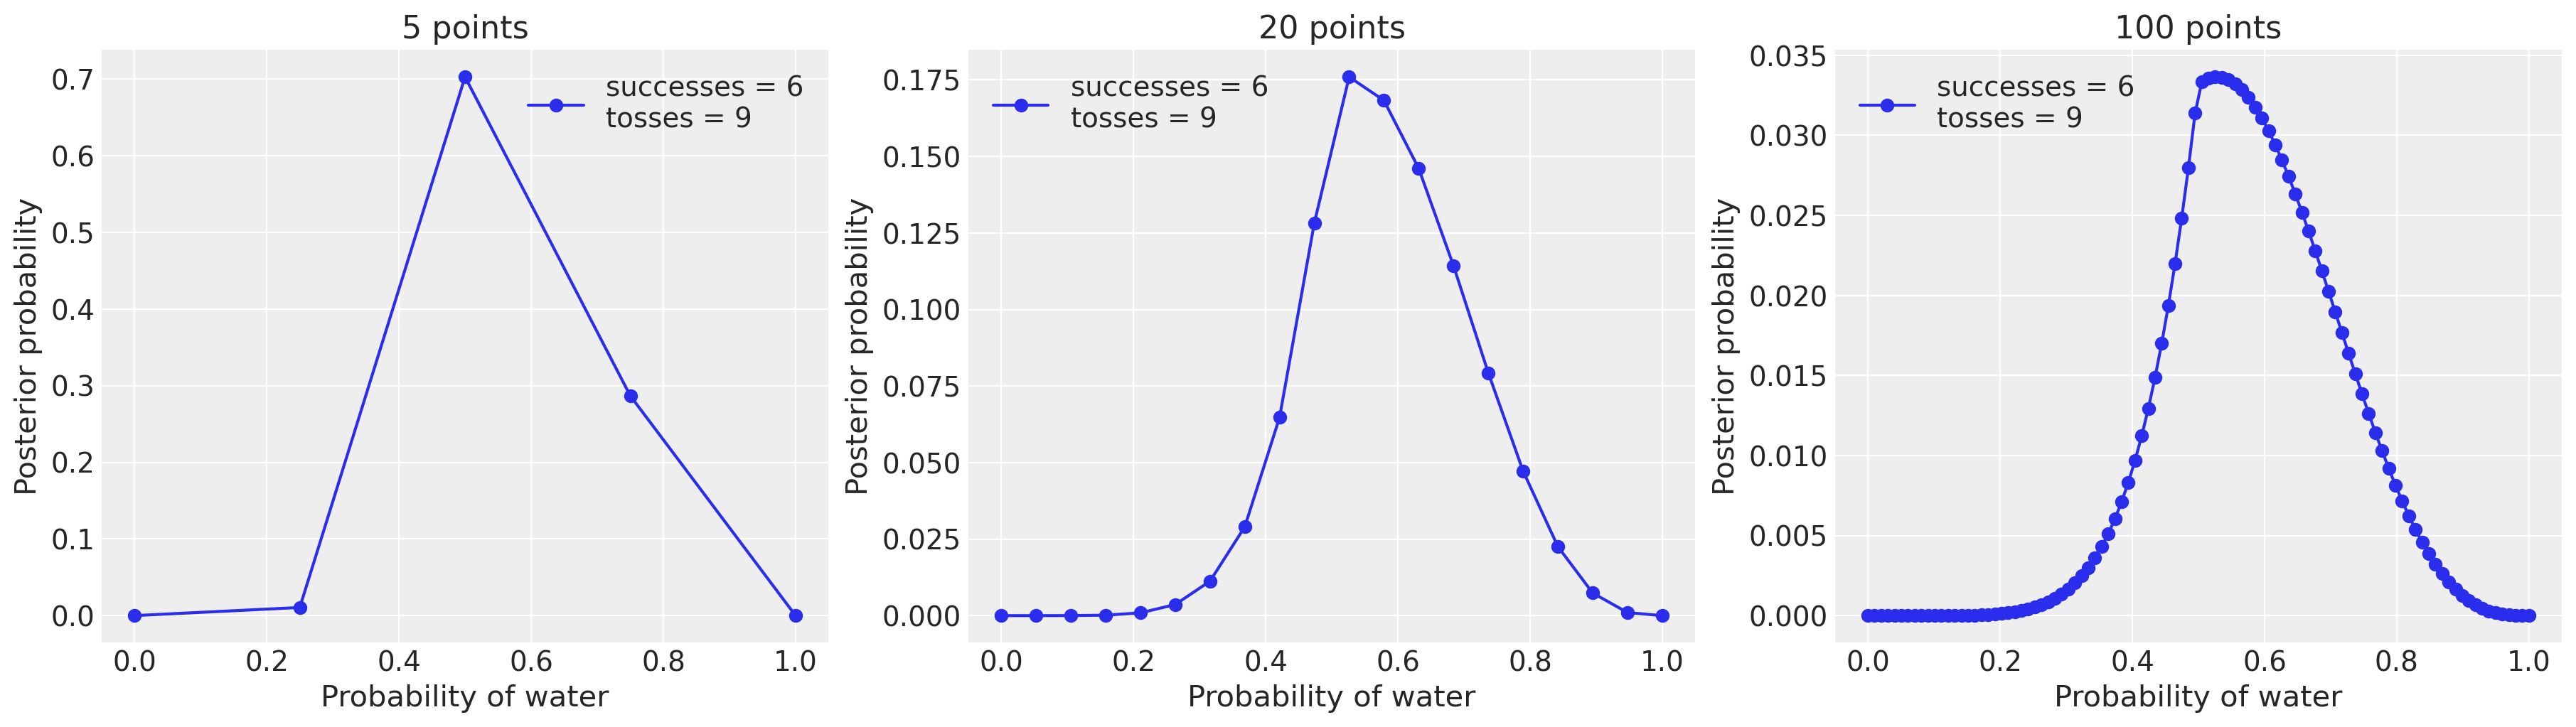

In [12]:
_, ax = plt.subplots(1, len(points), figsize=(6 * len(points), 5))
for idx, ps in enumerate(points):
    p_grid, posterior = binom_post_grid_approx(double_exp_prior, ps, w, n)
    ax[idx].plot(p_grid, posterior, "o-", label=f"successes = {w}\ntosses = {n}")
    ax[idx].set_xlabel("Probability of water")
    ax[idx].set_ylabel("Posterior probability")
    ax[idx].set_title(f"{ps} points")
    ax[idx].legend(loc=0)

## 2.6

In [48]:
np.repeat((0, 1), (3, 6))

array([0, 0, 0, 1, 1, 1, 1, 1, 1])

In [14]:
data = np.repeat((0, 1), (3, 6))
with pm.Model() as normal_approximation:
    p = pm.Uniform("p", lower=0, upper=1)
    w = pm.Binomial("w", n=len(data), p=p, observed=data.sum())
    mean_q = pm.find_MAP()
    
    p_value = normal_approximation.rvs_to_values[p]
    p_value.tag.transform = None
    p_value.name = p.name
    
    std_q = ((1 / pm.find_hessian(mean_q, vars=[p])) ** 0.5)[0]
    
print("Mean, Standard Deviation\np {:.2}, {:.2}".format(mean_q["p"], std_q[0]))


Mean, Standard Deviation
p 0.67, 0.16


In [15]:
# Compute the 89th percentile credible interval
norm = stats.norm(mean_q, std_q)
prob = 0.89
z = stats.norm.ppf([(1 - prob) / 2, (1 + prob) / 2])
pi = mean_q["p"] + std_q * z
print("5.5%, 94.5% \n{:.2}, {:.2}".format(pi[0], pi[1]))

5.5%, 94.5% 
0.42, 0.92


## 2.7

Text(0.5, 0, 'Proportion of water')

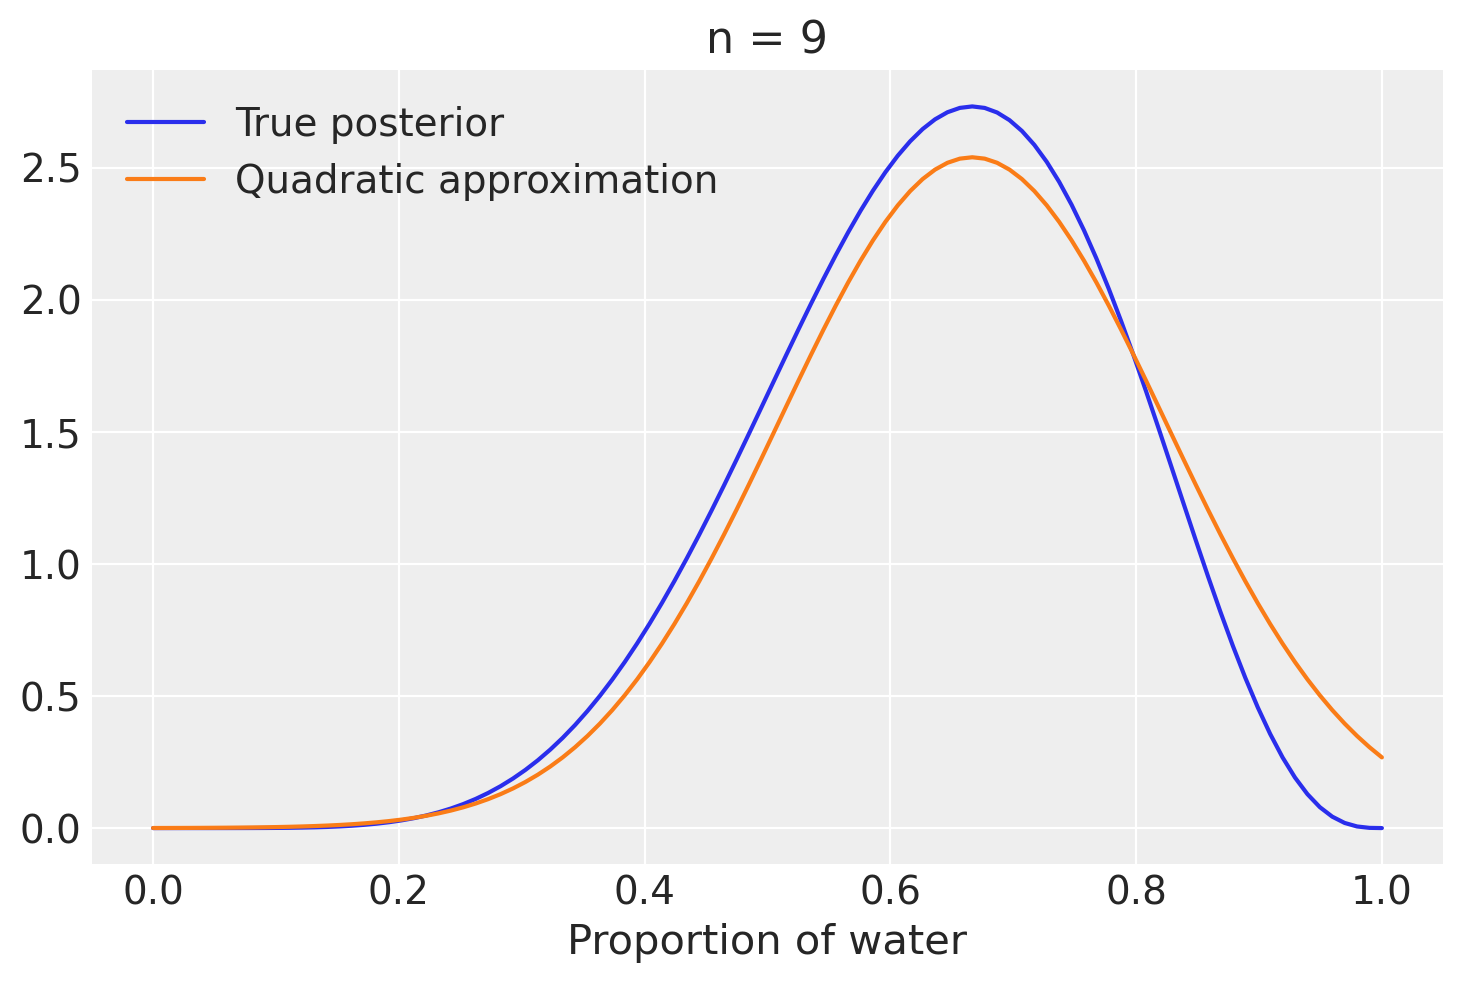

In [16]:
w, n = 6, 9
x = np.linspace(0, 1, 100)
plt.plot(x, stats.beta.pdf(x, w + 1, n - w + 1), label="True posterior")

# Quadratic approximation
plt.plot(x, stats.norm.pdf(x, mean_q["p"], std_q), label="Quadratic approximation")
plt.legend(loc=0)

plt.title(f"n = {n}")
plt.xlabel("Proportion of water")

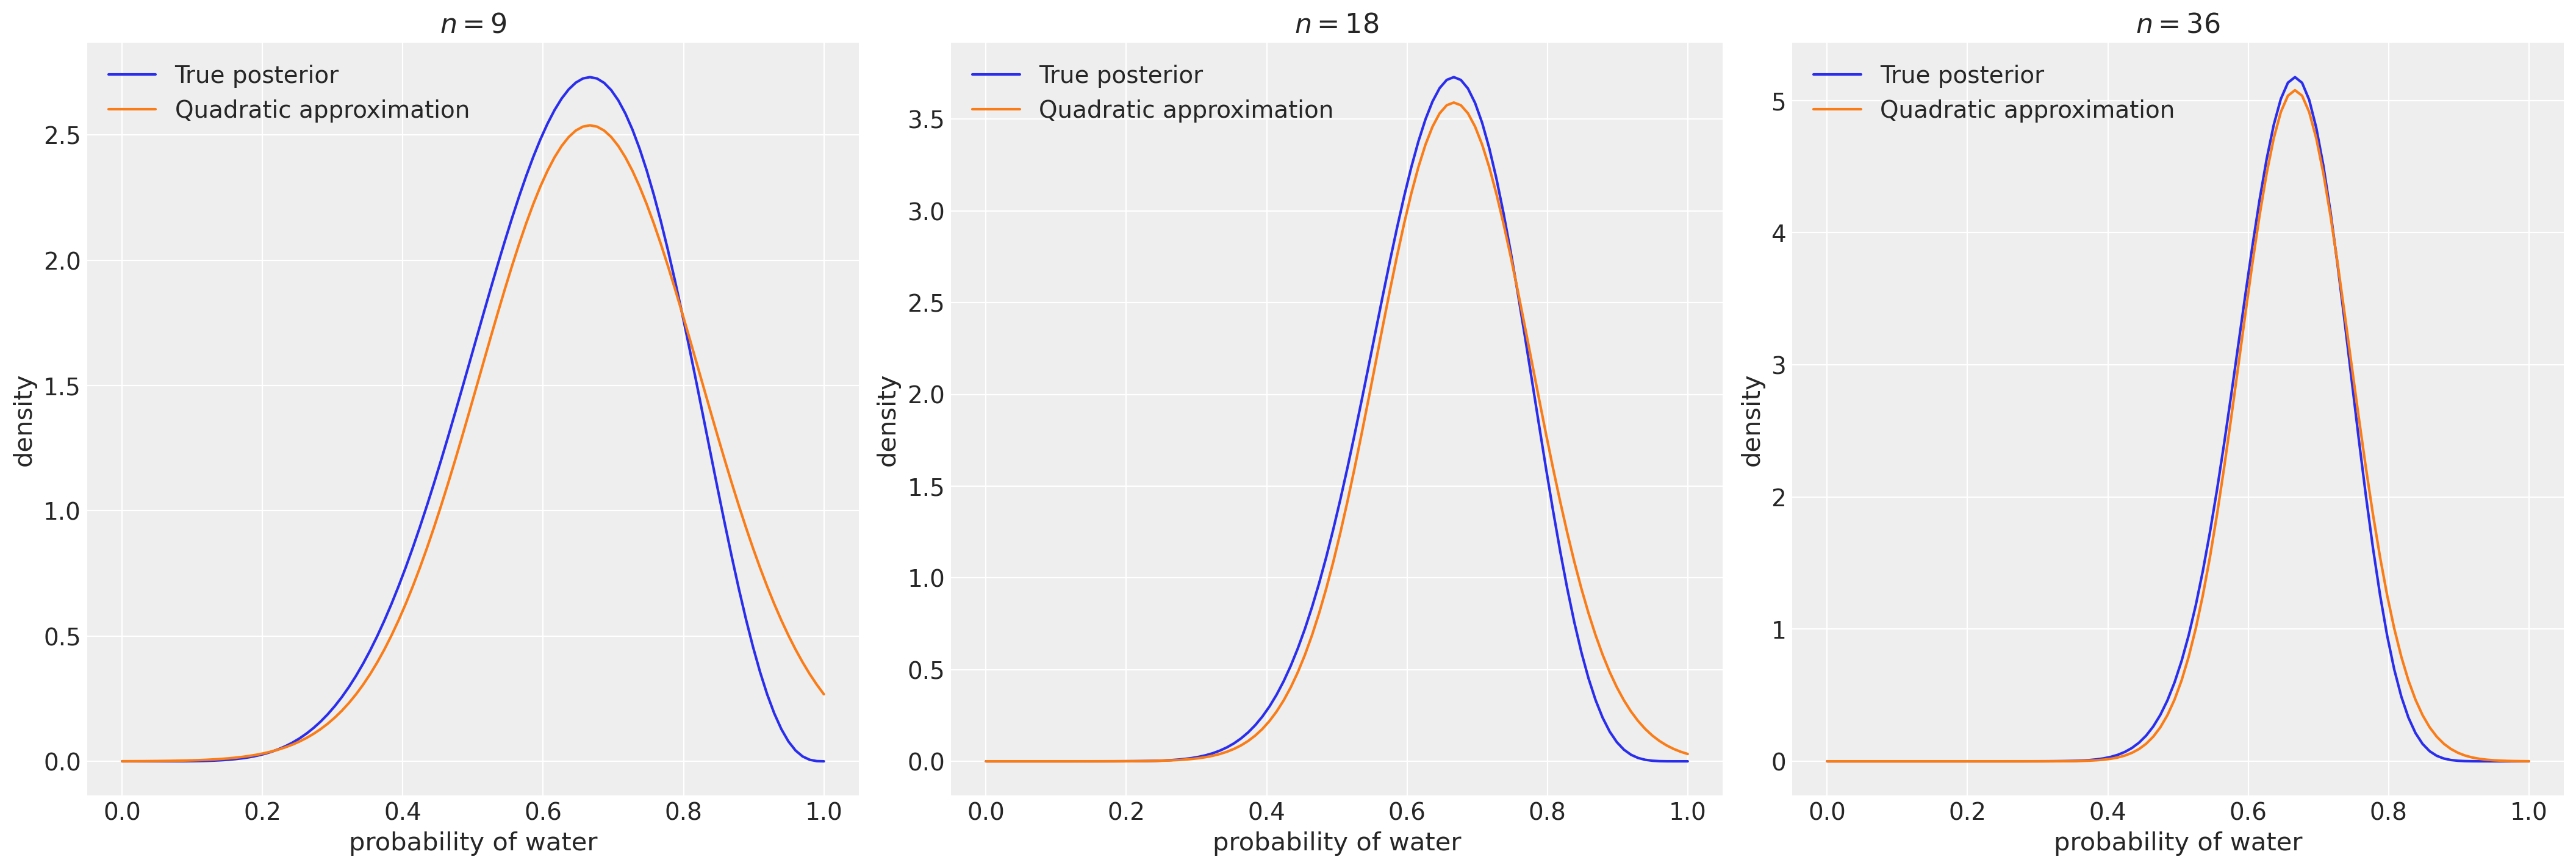

In [21]:
x = np.linspace(0, 1, 100)
w, n = [6, 12, 24], [9, 18, 36]

fig, ax = plt.subplots(1, 3, figsize=(21, 7))

for idx, ps in enumerate(zip(w, n)):
    data = np.repeat((0, 1), (ps[1] - ps[0], ps[0]))
    with pm.Model() as normal_approximation:
        p = pm.Uniform("p", 0, 1)  # uniform priors
        w = pm.Binomial("w", n=len(data), p=p, observed=data.sum())  # binomial likelihood
        mean_q = pm.find_MAP()

        p_value = normal_approximation.rvs_to_values[p]
        p_value.tag.transform = None
        p_value.name = p.name

        std_q = ((1 / pm.find_hessian(mean_q, vars=[p])) ** 0.5)[0]

    ax[idx].plot(x, stats.beta.pdf(x, ps[0] + 1, ps[1] - ps[0] + 1), label="True posterior")
    ax[idx].plot(x, stats.norm.pdf(x, mean_q["p"], std_q), label="Quadratic approximation")
    ax[idx].set_xlabel("probability of water")
    ax[idx].set_ylabel("density")
    ax[idx].set_title(r"$n={}$".format(ps[1]))
    ax[idx].legend(loc="upper left")

## 2.8


In [22]:
n_samples = 1000
p = np.zeros(n_samples)
p[0] = 0.5
W = 6
L = 3
for i in range(1, n_samples):
    p_new = stats.norm(p[i - 1], 0.1).rvs(1)
    if p_new < 0:
        p_new = -p_new
    if p_new > 1:
        p_new = 2 - p_new
    q0 = stats.binom.pmf(W, n=W + L, p=p[i - 1])
    q1 = stats.binom.pmf(W, n=W + L, p=p_new)
    if stats.uniform.rvs(0, 1) < q1 / q0:
        p[i] = p_new
    else:
        p[i] = p[i - 1]

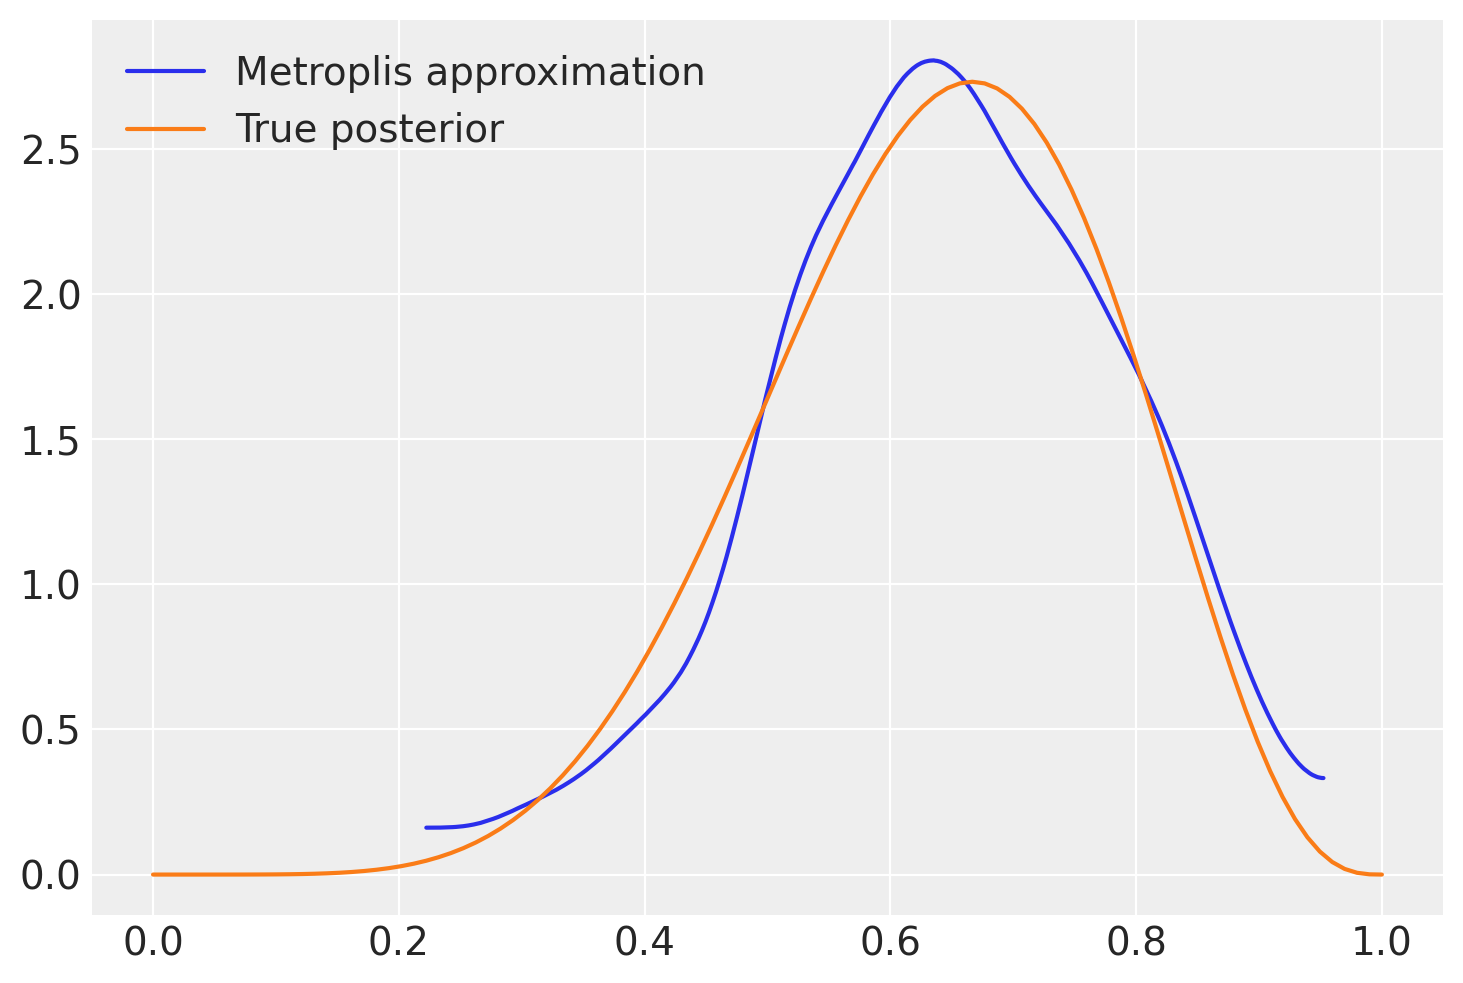

In [25]:
az.plot_kde(p, label="Metroplis approximation")
x = np.linspace(0, 1, 100)
plt.plot(x, stats.beta.pdf(x, W + 1, L + 1), "C1", label="True posterior")
plt.legend()